In [ ]:
# Zack ,Cell Seeding Efficiency Measure - Cell 0: Mount Google Drive

from google.colab import drive

drive.mount('/content/drive/' , force_remount=True)

Mounted at /content/drive/


In [ ]:
# Zack ,Cell Seeding Efficiency Measure - Cell 1: Setup & Imports
!pip install cellpose

import os
import numpy as np
import cv2
import tifffile
import matplotlib.pyplot as plt
from cellpose import models, io
from segment_anything import SamPredictor, sam_model_registry


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.

In [ ]:
# Zack ,Cell Seeding Efficiency Measure - Cell 2: Load Sample Image
import os

#os.makedirs("/sample_data/Projects", exist_ok=True)

#!cp -rf "/content/drive/MyDrive/cellpose_sam_spheres/" "/sample_data/Projects/"

image_path = '/content/drive/MyDrive/cellpose_sam_spheres/data/raw/spheres.tif'
img = tifffile.imread(image_path)
print("Image shape:", img.shape)

Image shape: (161, 960, 1280)


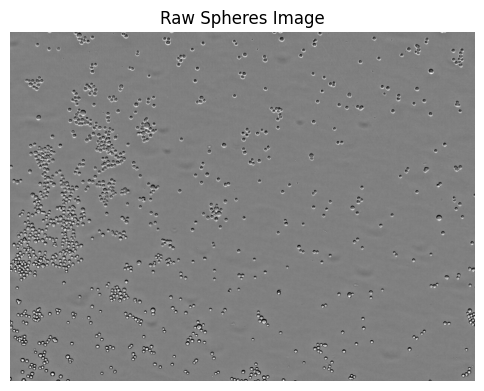

In [ ]:
# Zack ,Cell Seeding Efficiency Measure - Cell 3: Visualize Image

plt.figure(figsize=(6, 6))
plt.imshow(img[0], cmap='gray')
plt.title("Raw Spheres Image")
plt.axis("off")
plt.show()

In [ ]:
# Zack ,Cell Seeding Efficiency Measure - Cell 4: Load Cellpose & SAM Models

cellpose_model = models.CellposeModel(model_type='cyto2')

!curl -L https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -o "/content/drive/MyDrive/cellpose_sam_spheres/sam_vit_h.pth"

sam_checkpoint = "/content/drive/MyDrive/cellpose_sam_spheres/sam_vit_h.pth"
sam = sam_model_registry["vit_h"](checkpoint=sam_checkpoint)
sam_predictor = SamPredictor(sam)


100%|██████████| 1.15G/1.15G [00:05<00:00, 216MB/s]


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2445M  100 2445M    0     0  30.0M      0  0:01:21  0:01:21 --:--:-- 54.2M


In [ ]:
#Zack, Cell Seeding Efficiency Measure - Cell 5 : Optimized SAM + Cellpose Segmentation

single_img = img[0] if img.ndim == 3 else img
image_rgb = np.stack([single_img]*3, axis=-1)

sam_predictor.set_image(image_rgb)

input_point = np.array([[150, 150], [300, 300]])
input_label = np.array([1, 1])

masks_sam, _, _ = sam_predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False
)

roi_mask = masks_sam[0].astype(np.uint8)
if roi_mask.shape != single_img.shape:
    roi_mask = cv2.resize(roi_mask, (single_img.shape[1], single_img.shape[0]))

roi_img = cv2.bitwise_and(single_img, single_img, mask=roi_mask)

overlay_img = cv2.resize(roi_img, (roi_img.shape[1] // 4, roi_img.shape[0] // 4),interpolation=cv2.INTER_AREA)


if 'cellpose_model' not in globals():
    cellpose_model = models.CellposeModel(gpu=True)

masks, flows, styles = cellpose_model.eval(
    [overlay_img],
    diameter=30,
    flow_threshold=0.4,
    do_3D=False,
    stitch_threshold=0.0,
    progress=False,
    min_size=15
)

global last_masks
last_masks = masks

ValueError: not enough values to unpack (expected 4, got 3)

In [55]:
# Zack,Cell Seeding Efficiency Measure - Cell 6: Generate Class-wise Masks

classified_masks = {
    "circular_live": (last_masks[0] == 1).astype(np.uint8),
    "fixed": (last_masks[0] == 2).astype(np.uint8),
    "dead": (last_masks[0] == 3).astype(np.uint8),
    "fragments": (last_masks[0] == 4).astype(np.uint8)
}

print("Class-wise masks generated:", list(classified_masks.keys()))

Class-wise masks generated: ['circular_live', 'fixed', 'dead', 'fragments']


In [56]:
# Zack ,Cell Seeding Efficiency Measure - Cell 7: Save Masks to results/masks/

for label ,mask in classified_masks.items():
    cv2.imwrite(f'/content/drive/MyDrive/cellpose_sam_spheres/results/masks/{label}.png', (mask * 255).astype(np.uint8))

In [58]:
# Zack ,Cell Seeding Efficiency Measure - Cell 8: Generate Overlay AVI Videos

base_img = img[0] if img.ndim == 3 else img

mask = (last_masks[0]> 0).astype(np.uint8) * 255
mask_resized = cv2.resize(mask, (base_img.shape[1], base_img.shape[0]), interpolation=cv2.INTER_NEAREST)

base_rgb = cv2.cvtColor(base_img.astype(np.uint8), cv2.COLOR_GRAY2BGR)
mask_rgb = cv2.cvtColor(mask_resized, cv2.COLOR_GRAY2BGR)

overlay = cv2.addWeighted(base_rgb, 0.7, mask_rgb, 0.3, 0)

video_out = cv2.VideoWriter(
    '/content/drive/MyDrive/cellpose_sam_spheres/results/videos/overlay.avi',
    cv2.VideoWriter_fourcc(*'XVID'),
    10,
    (overlay.shape[1], overlay.shape[0]),
    True
)

for _ in range(10):
    video_out.write(overlay)

video_out.release()

In [60]:
# Zack ,Cell Seeding Efficiency Measure - Cell 9: Calculate Metrics (Area, Brightness)

metrics = []
labeled_mask = cv2.resize(last_masks[0], (img.shape[2], img.shape[1]), interpolation=cv2.INTER_NEAREST)

base_img = img[0] if img.ndim == 3 else img

for region_id in np.unique(labeled_mask):
    if region_id == 0:
        continue
    region_mask = labeled_mask == region_id
    brightness = np.mean(base_img[region_mask])
    area = np.sum(region_mask)
    metrics.append({
        "region": region_id,
        "brightness": brightness,
        "area": area
    })

import pandas as pd
pd.DataFrame(metrics).to_csv("/content/drive/MyDrive/cellpose_sam_spheres/results/metrics.csv", index=False)

In [ ]:
# Zack ,Cell Seeding Efficiency Measure - Cell 10: Wrap-up

print("Segmentation complete. Results saved to results/")